In [22]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt

# 1. Load session log
path = "Fixed_cleaned_activities.csv"   # <- update if your file lives elsewhere
df = pd.read_csv(path)

In [23]:
# 2. Pre-processing & feature engineering -----------------------------
# Parse timestamps and sort (required for rolling windows)
df['Begin Timestamp'] = pd.to_datetime(df['Begin Timestamp'],
                                       dayfirst=True, errors="coerce")
df = df.sort_values("Begin Timestamp").reset_index(drop=True)

# External load proxy: distance per session
df["load"] = df["Distance (Raw)"]

# Rolling loads
df["acute_load"] = (
    df.set_index("Begin Timestamp")["load"]
      .rolling(window="7D", min_periods=1).sum()
      .values
)

df["chronic_load"] = (
    df.set_index("Begin Timestamp")["load"]
      .rolling(window="28D", min_periods=7).sum()
      .values / 4.0        # 4-wk average weekly load
)

df["acwr"] = df["acute_load"] / df["chronic_load"]
df["acwr"].replace([np.inf, -np.inf], np.nan, inplace=True)

C:\Users\billt\AppData\Local\Temp\ipykernel_21880\910496171.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["acwr"].replace([np.inf, -np.inf], np.nan, inplace=True)


In [25]:
# 3. Binary label: high-risk if ACWR > 1.5
df["injury_risk"] = np.where(df["acwr"] > 1.5, 1, 0)

In [27]:
# 4. Feature matrix / target vector -----------------------------------
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
for drop in ["injury_risk", "Activity ID", "load",
             "acute_load", "chronic_load", "acwr"]:
    numeric_cols = [c for c in numeric_cols if c != drop]

X = df[numeric_cols]
y = df["injury_risk"]

# Train–test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

In [28]:
# 5. Pipeline: Impute → Scale → Random Forest -------------------------
pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        n_jobs=-1
    ))
])

pipe.fit(X_train, y_train)

,steps,"[('imputer', ...), ('scaler', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,missing_values,nan
,strategy,'median'
,fill_value,None
,copy,True
,add_indicator,False
,keep_empty_features,False
,copy,True



Classification report

              precision    recall  f1-score   support

           0       0.89      0.96      0.93        26
           1       0.67      0.40      0.50         5

    accuracy                           0.87        31
   macro avg       0.78      0.68      0.71        31
weighted avg       0.86      0.87      0.86        31

ROC AUC:  0.9076923076923077


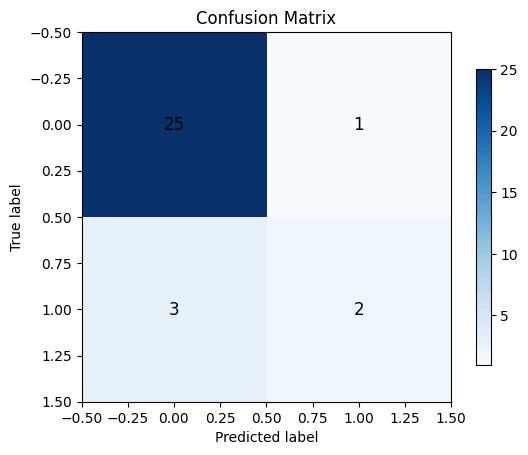

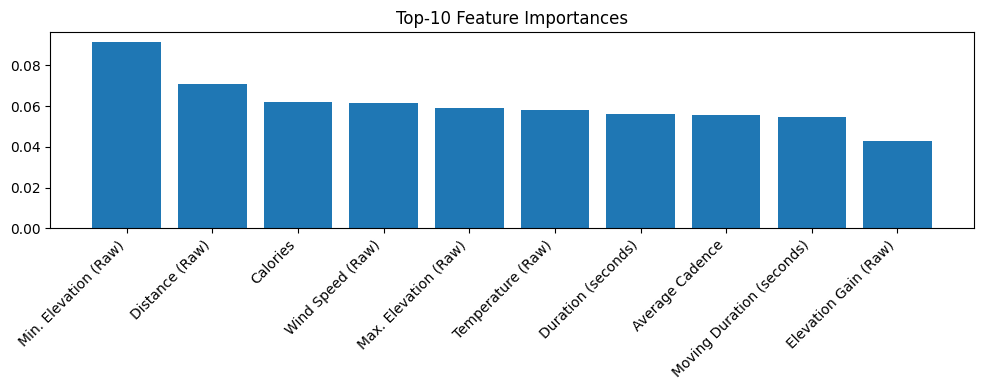

In [29]:
# 6. Evaluation --------------------------------------------------------
print("\nClassification report\n")
print(classification_report(y_test, pipe.predict(X_test)))

print("ROC AUC: ",
      roc_auc_score(y_test, pipe.predict_proba(X_test)[:, 1]))

# Confusion-matrix plot
cm = confusion_matrix(y_test, pipe.predict(X_test))
fig1, ax1 = plt.subplots()
im = ax1.imshow(cm, cmap="Blues")
ax1.set_xlabel("Predicted label")
ax1.set_ylabel("True label")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax1.text(j, i, cm[i, j], ha="center", va="center", fontsize=12)
plt.title("Confusion Matrix")
plt.colorbar(im, shrink=0.8)
plt.show()

# 7. Feature-importance chart -----------------------------------------
importances = pipe.named_steps["clf"].feature_importances_
idx = np.argsort(importances)[::-1][:10]      # top-10
top_names = [numeric_cols[i] for i in idx]

plt.figure(figsize=(10, 4))
plt.bar(range(len(idx)), importances[idx])
plt.xticks(range(len(idx)), top_names, rotation=45, ha="right")
plt.title("Top-10 Feature Importances")
plt.tight_layout()
plt.show()